In [1]:
!pip install sarabande
!pip install structify-net

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 1.7 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
import seaborn as sns
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os

import structify_net as stn
import structify_net.viz as viz
import structify_net.zoo as zoo
import structify_net.scoring as scoring
import numpy as np

import sarabande


In [57]:
def Make_rank_matrix(rank_model,nodeOrder=None,ax=None,**kwargs):
    """
    Plot a matrix of the graph, ordered by nodePair_order
    graph: a networkx graph
    nodePair_order: a list of node pairs, from the most likely to the less likely
    nodeOrder: a list of nodes, ordered by the order in which they should appear in the matrix
    """
    nodePair_order=rank_model.sortedPairs
    if nodeOrder!=None:
        n=len(nodeOrder)
    else:
        n=len(set([n for e in nodePair_order for n in e]))


    matrix = np.zeros((n,n))
    for i,e in enumerate(nodePair_order):
        e_l=list(e)
        matrix[e_l[0],e_l[1]]=i
        matrix[e_l[1],e_l[0]]=i

    if nodeOrder!=None:
        matrix=matrix[nodeOrder,:]
        matrix=matrix[:,nodeOrder]

    heatmap_args={'cmap':"YlGnBu_r",'cbar':False,'xticklabels':False,'yticklabels':False}
    for k,v in kwargs.items():
        heatmap_args[k]=v

    #m = sns.heatmap(matrix,cmap="YlGnBu_r",cbar=False,cbar_kws={'label': 'Rank'},xticklabels=False,yticklabels=False,ax=ax)
    #m = sns.heatmap(matrix,ax=ax,**heatmap_args)

    return matrix


def make_matrix_PCF(n=128,p=0.1,epsilon=0.1):
  plt.close('all')
  all_mods = zoo.get_all_rank_models(n=n,m=(n*p)**2.)
  name_models = all_mods.keys()
  for name in name_models:
    print('/n'+f'Model Name : {name}')
    rank_model = all_mods[name]
    os.makedirs(f'/content/drive/MyDrive/Texture_PCF/{name}_p{p}_ep{epsilon}', exist_ok=True)
    matrix = Make_rank_matrix(rank_model,nodeOrder = rank_model.node_order)
    matrix = matrix/np.max(matrix)
    plt.figure(figsize=(10,10))
    plt.imshow(matrix,cmap='RdYlBu_r')
    plt.title(f'Model Name : {name}')
    plt.gca().set_xlabel("x-axis", fontsize=35)
    plt.gca().set_ylabel("y-axis", fontsize=35)
    plt.colorbar()
    plt.savefig(f'/content/drive/MyDrive/Texture_PCF/{name}_p{p}_ep{epsilon}/Prob_Density-{name}_p{p}_ep{epsilon}.png')
    plt.close()

    gpx = rank_model.generate_graph(epsilon=epsilon,density=p)
    G_grid_array = nx.to_numpy_array(gpx)
    plt.figure(figsize=(10,10))
    plt.imshow(G_grid_array,cmap='gray')
    plt.title(f'Model Name Realization : {name}')
    plt.gca().set_xlabel("x-axis", fontsize=35)
    plt.gca().set_ylabel("y-axis", fontsize=35)
    plt.colorbar()
    plt.savefig(f'/content/drive/MyDrive/Texture_PCF/{name}_p{p}_ep{epsilon}/Realization-{name}_p{p}_ep{epsilon}.png')
    plt.close()

    #string to directory to save data into
    save_dir = os.getcwd() + '/output/'
    os.makedirs(save_dir, exist_ok=True)
    ### With prob ..
    #create measure_obj
    projected_3PCF = sarabande.measure(nPCF=3, projected=True, m_max=11,
                                      density_field_data = G_grid_array,
                                      save_dir=save_dir, save_name='example',
                                      nbins=40, physical_boxsize=n, rmin=1e-14, rmax=int(n/2),
                                      normalize=True)

    sarabande.calc_zeta(projected_3PCF, verbose_flag=True)

    m_values = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
    fig, axs = plt.subplots(3,4, figsize=(20,12))

    for m,ax1 in zip(m_values,axs.flatten()):
      img = projected_3PCF.zeta[m, :,:]

      # Real Part (left)
      im1 = ax1.imshow(img.real, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.real)),vmax= np.max(np.abs(img.real)))
      ax1.set_title(f"Real Part: m = {m}-mode", pad = 10)
      divider1 = axgrid.make_axes_locatable(ax1)
      cax1 = divider1.append_axes("right", size='5%', pad=0.05)
      plt.colorbar(im1, cax=cax1)
      # # Imaginary Part (right)
      # im2 = ax2.imshow(img.imag, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.imag)),vmax= np.max(np.abs(img.imag)))
      # ax2.set_title("Imaginary Part", pad = 10)
      # ax2.set_xlabel("$\mathrm{b}_1$", fontsize=30)
      # ax2.set_ylabel("$\mathrm{b}_2$", fontsize=30)
      # divider2 = axgrid.make_axes_locatable(ax2)
      # cax2 = divider2.append_axes("right", size='5%', pad=0.05)
      # plt.colorbar(im2, cax=cax2)

      # fig.suptitle("Projected 3PCF: $\\hat{\\zeta}^{\; \\mathrm{b}_1 \\mathrm{b}_2}_m$", fontsize=35)
    #fig.tight_layout()
    ax1.set_xlabel("$\mathrm{b}_1$", fontsize=30)
    ax1.set_ylabel("$\mathrm{b}_2$", fontsize=30)
    plt.savefig(f'/content/drive/MyDrive/Texture_PCF/{name}_p{p}_ep{epsilon}/3PCF_Realization-{name}_p{p}_ep{epsilon}.png')
    plt.close()

    #string to directory to save data into
    save_dir = os.getcwd() + '/output/'
    os.makedirs(save_dir, exist_ok=True)
    ### With prob ..
    #create measure_obj
    projected_3PCF = sarabande.measure(nPCF=3, projected=True, m_max=11,
                                      density_field_data = matrix,
                                      save_dir=save_dir, save_name='example',
                                      nbins=40, physical_boxsize=n, rmin=1e-14, rmax=int(n/2),
                                      normalize=True)

    sarabande.calc_zeta(projected_3PCF, verbose_flag=True)

    m_values = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
    fig, axs = plt.subplots(3,4, figsize=(20,12))

    for m,ax1 in zip(m_values,axs.flatten()):
      img = projected_3PCF.zeta[m, :,:]

      # Real Part (left)
      im1 = ax1.imshow(img.real, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.real)),vmax= np.max(np.abs(img.real)))
      ax1.set_title(f"Real Part: m = {m}-mode", pad = 10)
      divider1 = axgrid.make_axes_locatable(ax1)
      cax1 = divider1.append_axes("right", size='5%', pad=0.05)
      plt.colorbar(im1, cax=cax1)
      # # Imaginary Part (right)
      # im2 = ax2.imshow(img.imag, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.imag)),vmax= np.max(np.abs(img.imag)))
      # ax2.set_title("Imaginary Part", pad = 10)
      # ax2.set_xlabel("$\mathrm{b}_1$", fontsize=30)
      # ax2.set_ylabel("$\mathrm{b}_2$", fontsize=30)
      # divider2 = axgrid.make_axes_locatable(ax2)
      # cax2 = divider2.append_axes("right", size='5%', pad=0.05)
      # plt.colorbar(im2, cax=cax2)

      # fig.suptitle("Projected 3PCF: $\\hat{\\zeta}^{\; \\mathrm{b}_1 \\mathrm{b}_2}_m$", fontsize=35)
    #fig.tight_layout()
    ax1.set_xlabel("$\mathrm{b}_1$", fontsize=30)
    ax1.set_ylabel("$\mathrm{b}_2$", fontsize=30)
    plt.savefig(f'/content/drive/MyDrive/Texture_PCF/{name}_p{p}_ep{epsilon}/3PCF_Probability-{name}_p{p}_ep{epsilon}.png')
    plt.close()

    data_inp = (matrix*8).astype(int)
    print(data_inp.max())
    from skimage.feature import graycomatrix, graycoprops
    distances=[2,6,12]
    angles=[0,60,120,180,240,300]

    glcm = graycomatrix(
            data_inp, distances=distances,angles=angles, levels=9, symmetric=True, normed=True
        )

    dist_grid, ang_grid = np.meshgrid(distances,angles)

    dist_grid = dist_grid.flatten()
    ang_grid = ang_grid.flatten()

    fig, axs = plt.subplots(3,6, figsize=(20,12))
    for i,(ang_v,dist_v,ax1) in enumerate(zip(ang_grid,dist_grid,axs.flatten())):
        indx_ang = np.where(angles==ang_v)[0]
        indx_dist = np.where(distances==dist_v)[0]
        img = glcm[:,:,indx_dist,indx_ang]
        # Real Part (left)
        im1 = ax1.imshow(img, origin='lower', cmap='bwr',vmin= np.min(np.abs(img.real)),vmax= np.max(np.abs(img.real)))
        ax1.set_title(f"GLCM : {ang_v}-{dist_v}", pad = 10)
        divider1 = axgrid.make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size='5%', pad=0.05)
        plt.colorbar(im1, cax=cax1)

    # ax1.set_xlabel("$\mathrm{b}_1$", fontsize=30)
    # ax1.set_ylabel("$\mathrm{b}_2$", fontsize=30)
    plt.savefig(f'/content/drive/MyDrive/Texture_PCF/{name}_p{p}_ep{epsilon}/GCLM_Prob-{name}_p{p}_ep{epsilon}.png')
    plt.close()


In [58]:
make_matrix_PCF(n=128,p=0.6,epsilon=0.1)

/nModel Name : ER
Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 3PCF.

Finished Calculating the Projected 3PCF in 1.5905 seconds
Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 3PCF.

Finished Calculating the Projected 3PCF in 1.7296 seconds
8
/nModel Name : spatial
Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 3PCF.

Finished Calculating the Projected 3PCF in 2.3674 seconds
Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 3PCF.

Finished Calculating the Pr

In [47]:
%debug


> <ipython-input-44-64014e3b06b5>(166)make_matrix_PCF()
    164         indx_ang = np.where(angles==ang_v)[0]
    165         indx_dist = np.where(distances==dist_v)[0]
--> 166         img = glcm[:,:,indx_ang,indx_dist]
    167         # Real Part (left)
    168         im1 = ax1.imshow(img, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.real)),vmax= np.max(np.abs(img.real)))

ipdb> glcm.shape
(13, 13, 3, 6)
ipdb> indx_ang
array([3])
ipdb> angles
[0, 60, 120, 180, 240, 300]
ipdb> q


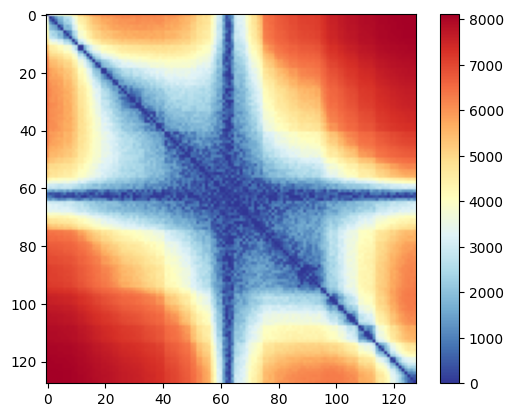

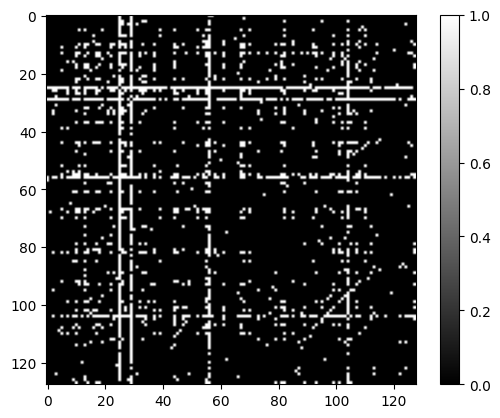

In [17]:
p=0.1
all_mods = zoo.get_all_rank_models(n=n,m=(n*p)**2.)
name_models = all_mods.keys()

rank_model = all_mods['core_distance']

matrix = Make_rank_matrix(rank_model,nodeOrder = rank_model.node_order)
plt.imshow(matrix,cmap='RdYlBu_r')
plt.colorbar()
plt.show()

gpx = rank_model.generate_graph(epsilon=0.1,density=p)
G_grid_array = nx.to_numpy_array(gpx)
plt.imshow(G_grid_array,cmap='gray')
plt.colorbar()

# fig, (ax1) = plt.subplots(1,1, figsize=(7,7))
# im1 = ax1.imshow(data, cmap='hot', origin='lower')
# # divider1 = axgrid.make_axes_locatable(ax1)
# # cax1 = divider1.append_axes("right", size='5%', pad=0.05)
# # plt.colorbar(im1, cax=cax1)
# ax1.set_title("Projected Density Field", fontsize=35, pad=15)
# ax1.set_xlabel("x-axis", fontsize=35)
# ax1.set_ylabel("y-axis", fontsize=35)
# ax1.set_xticks([])
# ax1.set_yticks([])
# fig.tight_layout()
# # plt.savefig("projected-example.png", dpi=300)
# plt.show()

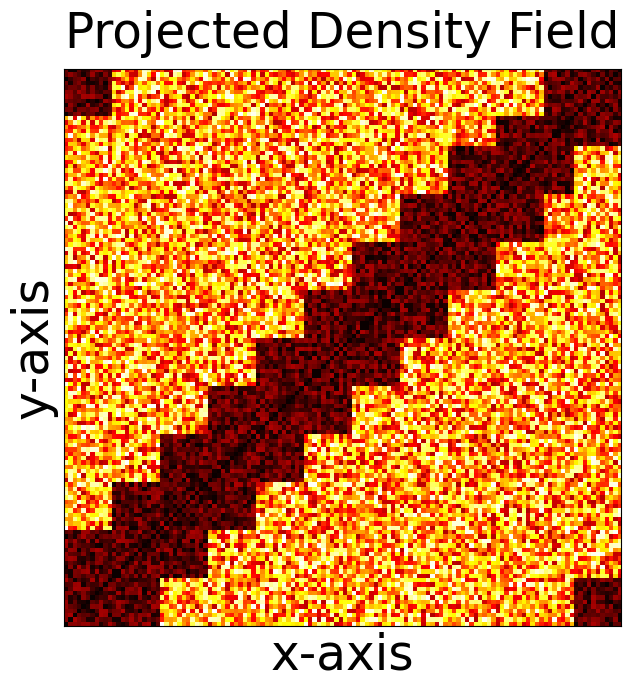

In [22]:
import os
#string to directory to save data into
save_dir = os.getcwd() + '/output/'
os.makedirs(save_dir, exist_ok=True)

#create measure_obj
projected_3PCF = sarabande.measure(nPCF=4, projected=True, m_max=5,
                                   density_field_data = matrix/np.max(matrix),
                                   save_dir=save_dir, save_name='example',
                                   nbins=40, physical_boxsize=128, rmin=1e-14, rmax=64,
                                   normalize=True)

sarabande.calc_zeta(projected_3PCF, verbose_flag=True)

Preparing the data:
Creating Radial Bins ... 

Creating kernels ... 

taking the fourier transform of data ... 

calculating C_m Coefficients ... 

Starting Calculation of Projected 4PCF.

Finished Calculating the Projected 4PCF in 160.0973 seconds


In [23]:
np.shape(projected_3PCF.zeta) # (m_max + 1, nbins, nbins)


(10, 10, 40, 40, 40)

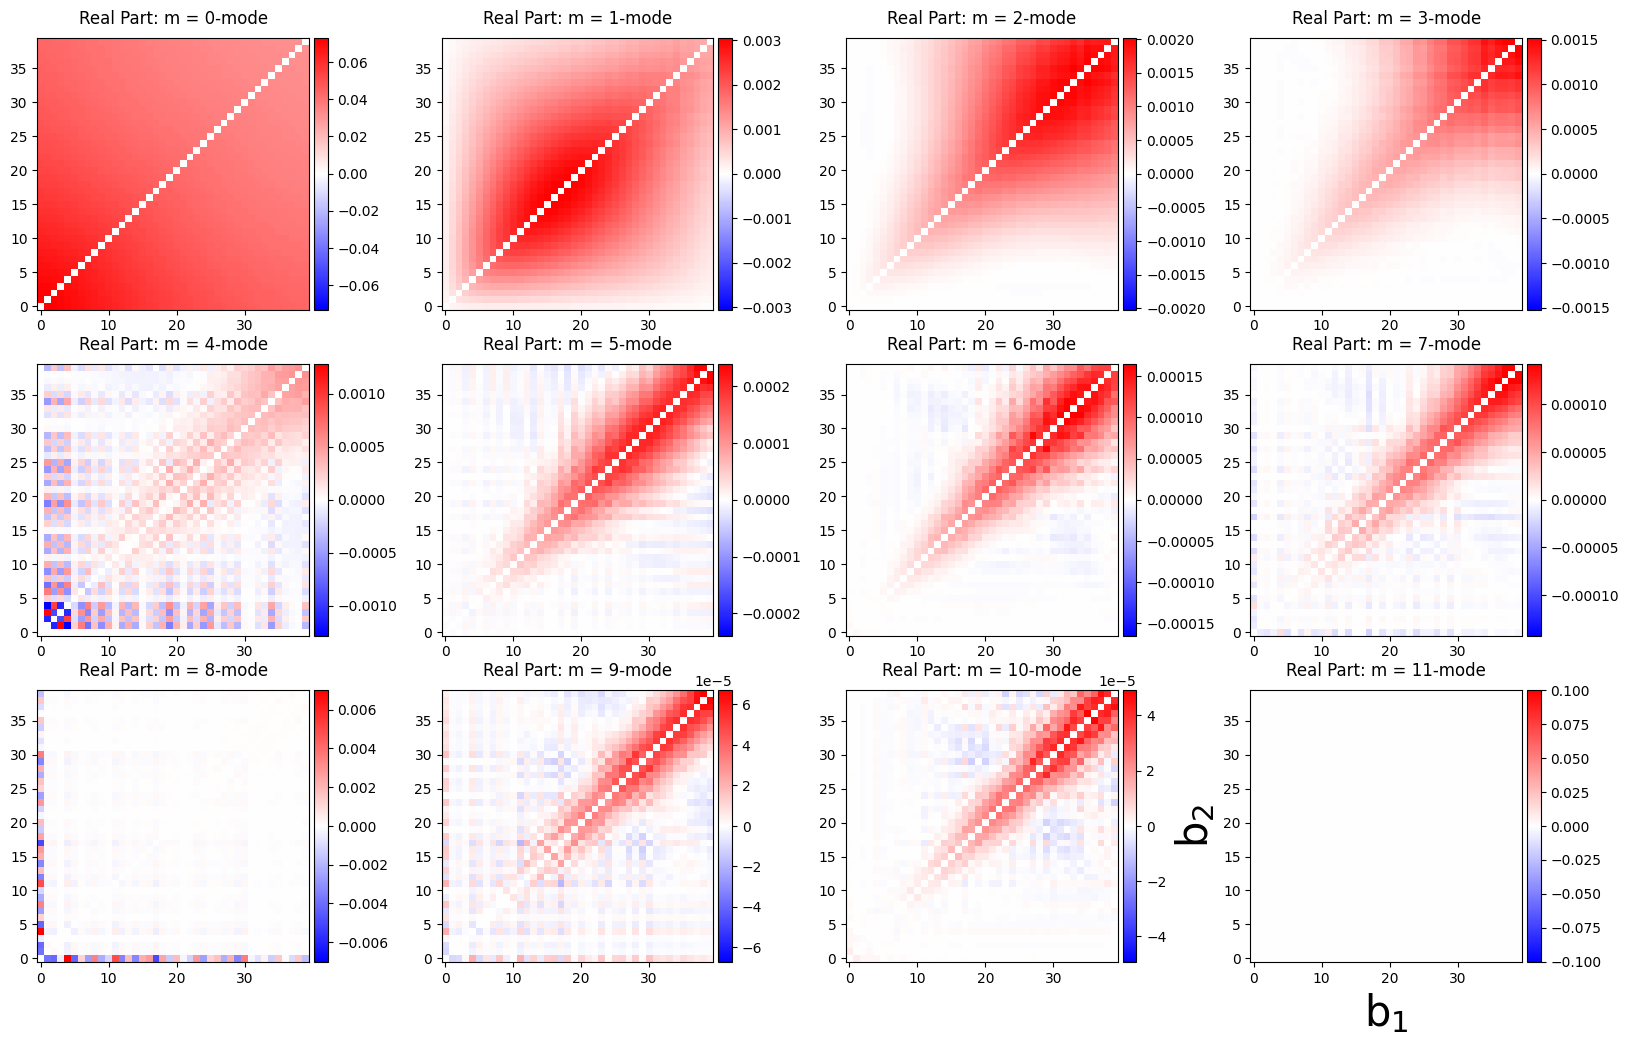

In [179]:
m_values = np.array([0,1,2,3,4,5,6,7,8,9,10,11])

fig, axs = plt.subplots(3,4, figsize=(20,12))

for m,ax1 in zip(m_values,axs.flatten()):
  img = projected_3PCF.zeta[m, :,:]

  # Real Part (left)
  im1 = ax1.imshow(img.real, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.real)),vmax= np.max(np.abs(img.real)))
  ax1.set_title(f"Real Part: m = {m}-mode", pad = 10)
  divider1 = axgrid.make_axes_locatable(ax1)
  cax1 = divider1.append_axes("right", size='5%', pad=0.05)
  plt.colorbar(im1, cax=cax1)



  # # Imaginary Part (right)
  # im2 = ax2.imshow(img.imag, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.imag)),vmax= np.max(np.abs(img.imag)))
  # ax2.set_title("Imaginary Part", pad = 10)
  # ax2.set_xlabel("$\mathrm{b}_1$", fontsize=30)
  # ax2.set_ylabel("$\mathrm{b}_2$", fontsize=30)
  # divider2 = axgrid.make_axes_locatable(ax2)
  # cax2 = divider2.append_axes("right", size='5%', pad=0.05)
  # plt.colorbar(im2, cax=cax2)

  # fig.suptitle("Projected 3PCF: $\\hat{\\zeta}^{\; \\mathrm{b}_1 \\mathrm{b}_2}_m$", fontsize=35)
#fig.tight_layout()
ax1.set_xlabel("$\mathrm{b}_1$", fontsize=30)
ax1.set_ylabel("$\mathrm{b}_2$", fontsize=30)
plt.show()

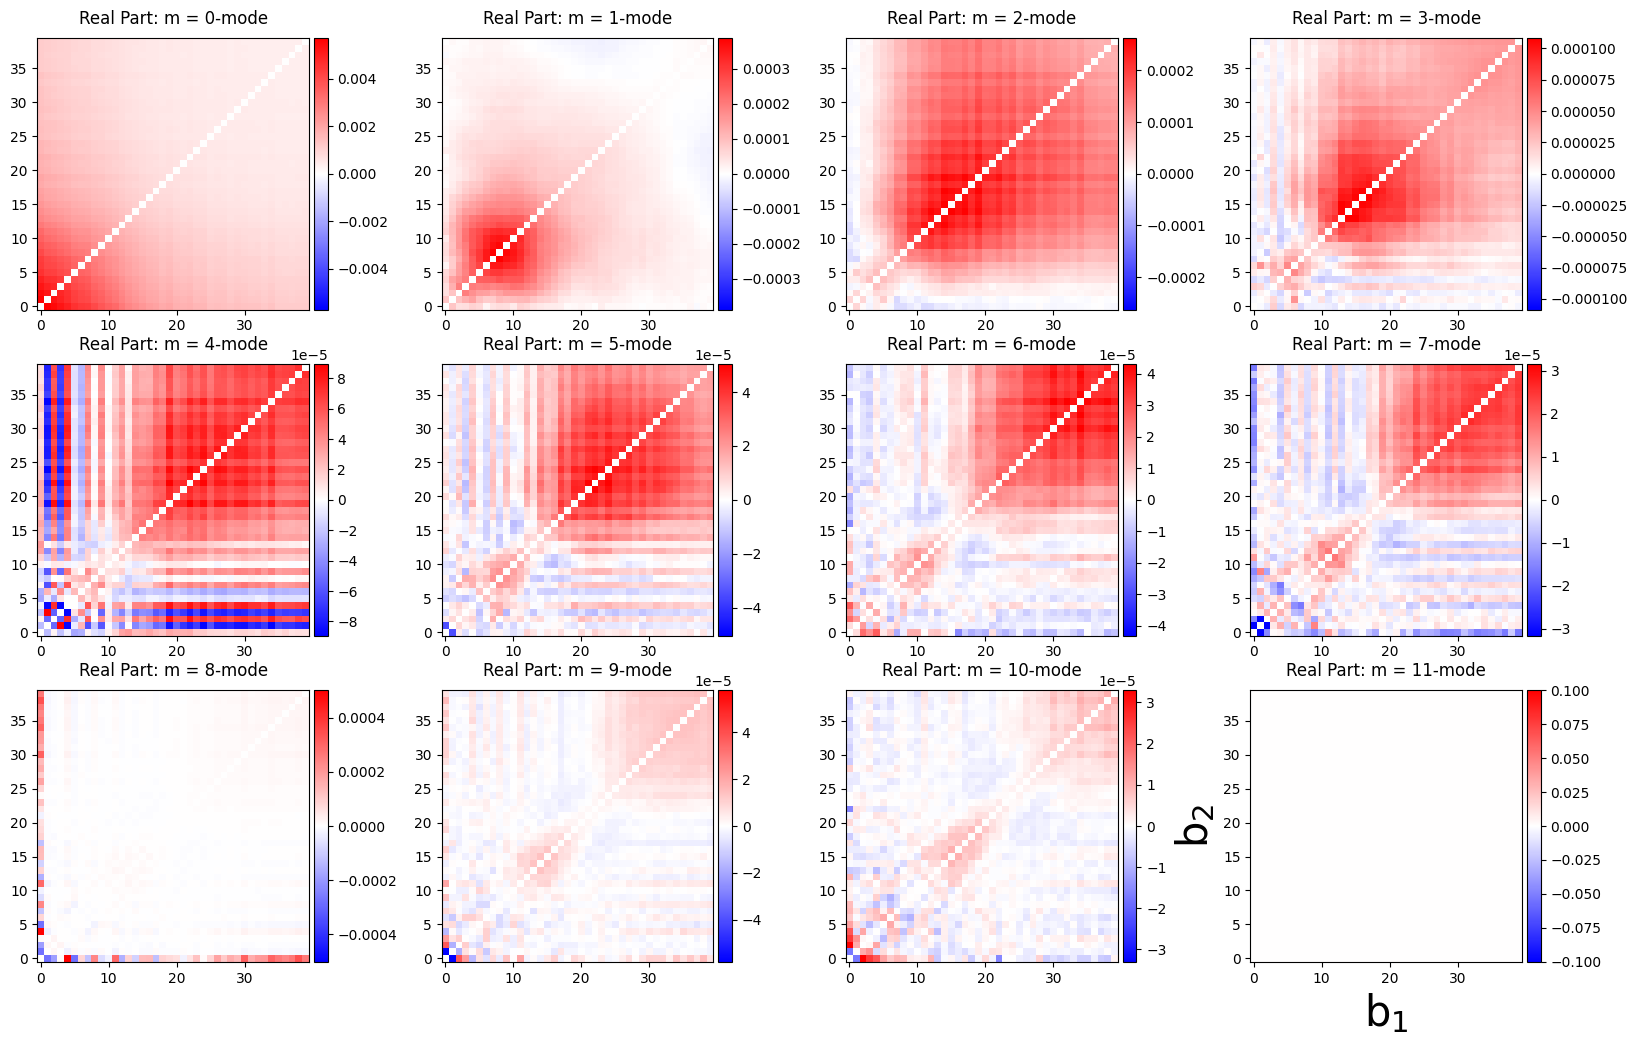

In [153]:
m_values = np.array([0,1,2,3,4,5,6,7,8,9,10,11])

fig, axs = plt.subplots(3,4, figsize=(20,12))

for m,ax1 in zip(m_values,axs.flatten()):
  img = projected_3PCF.zeta[m, :,:]

  # Real Part (left)
  im1 = ax1.imshow(img.real, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.real)),vmax= np.max(np.abs(img.real)))
  ax1.set_title(f"Real Part: m = {m}-mode", pad = 10)
  divider1 = axgrid.make_axes_locatable(ax1)
  cax1 = divider1.append_axes("right", size='5%', pad=0.05)
  plt.colorbar(im1, cax=cax1)



  # # Imaginary Part (right)
  # im2 = ax2.imshow(img.imag, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.imag)),vmax= np.max(np.abs(img.imag)))
  # ax2.set_title("Imaginary Part", pad = 10)
  # ax2.set_xlabel("$\mathrm{b}_1$", fontsize=30)
  # ax2.set_ylabel("$\mathrm{b}_2$", fontsize=30)
  # divider2 = axgrid.make_axes_locatable(ax2)
  # cax2 = divider2.append_axes("right", size='5%', pad=0.05)
  # plt.colorbar(im2, cax=cax2)

  # fig.suptitle("Projected 3PCF: $\\hat{\\zeta}^{\; \\mathrm{b}_1 \\mathrm{b}_2}_m$", fontsize=35)
#fig.tight_layout()
ax1.set_xlabel("$\mathrm{b}_1$", fontsize=30)
ax1.set_ylabel("$\mathrm{b}_2$", fontsize=30)
plt.show()

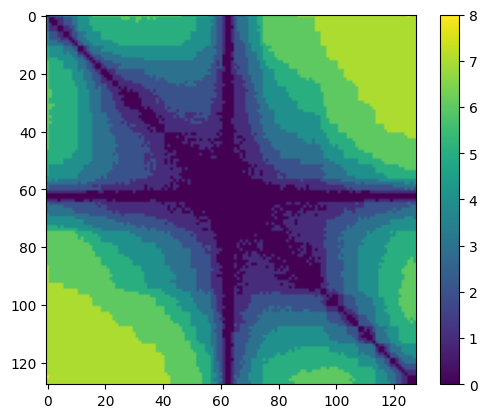

In [25]:
data_inp = (matrix/matrix.max()*8).astype(int)
plt.imshow(data_inp)
plt.colorbar()

In [52]:
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
distances=[2,4,6]
angles=[0,60,120,180,240,300]

glcm = graycomatrix(
        data_inp, distances=distances,angles=angles, levels=9, symmetric=True, normed=True
    )



In [53]:
glcm.shape

(9, 9, 3, 6)

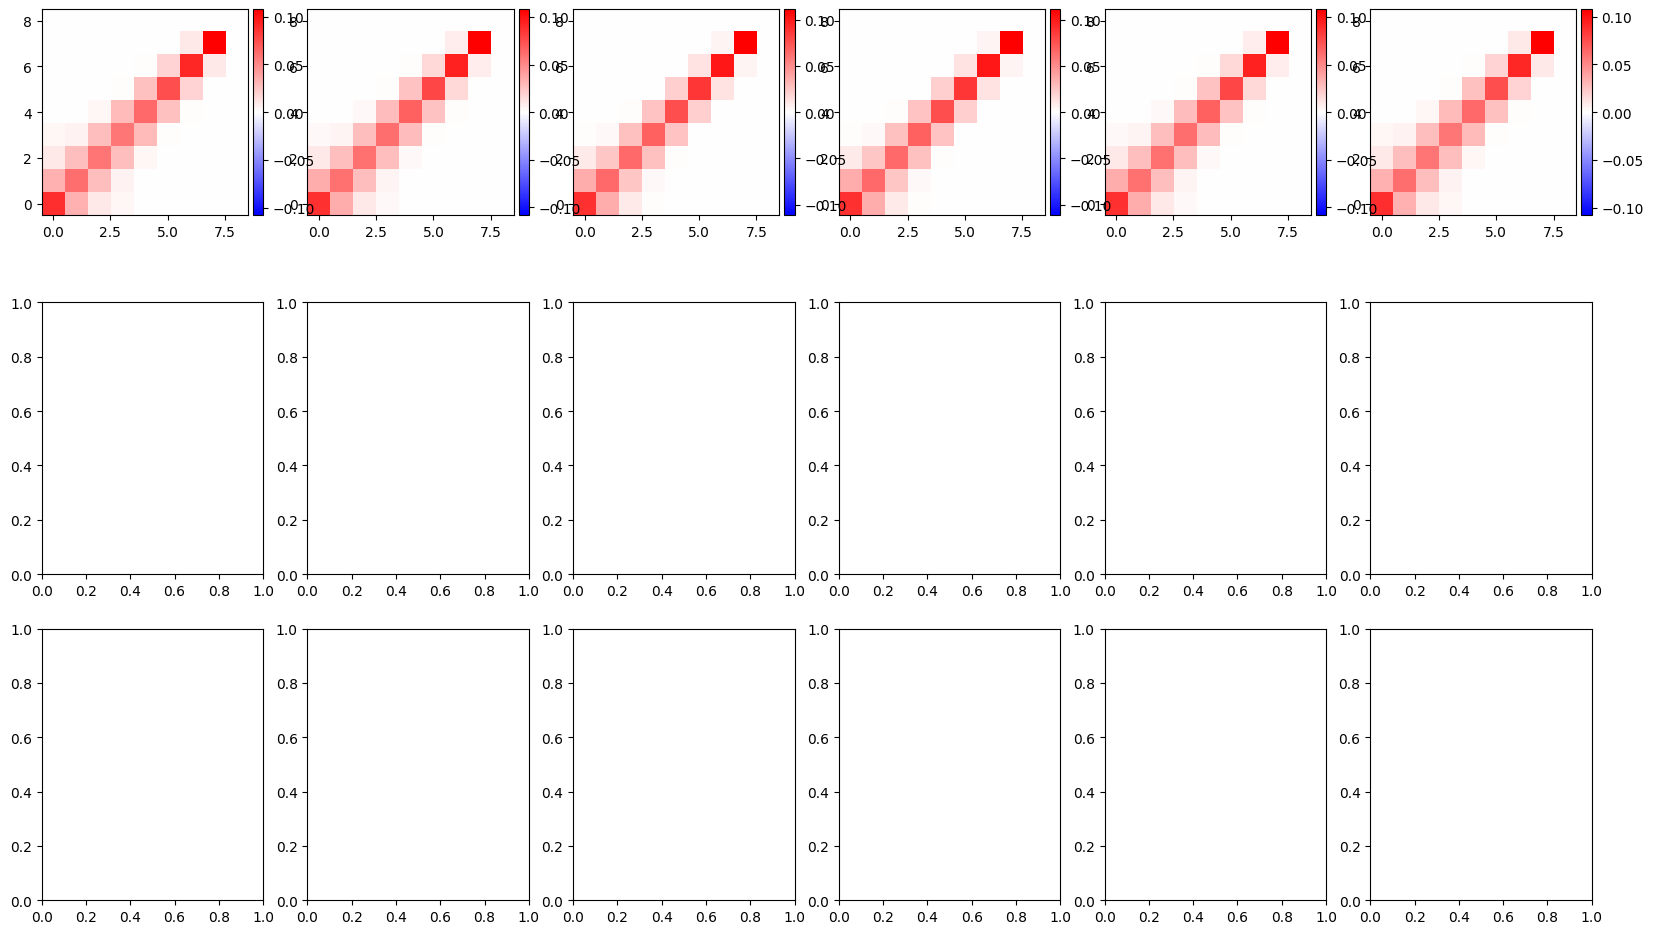

In [54]:
fig, axs = plt.subplots(3,6, figsize=(20,12))
for i,(m,ax1) in enumerate(zip(angles,axs.flatten())):
    img = glcm[:,:,1,i]
    # Real Part (left)
    im1 = ax1.imshow(img, origin='lower', cmap='bwr',vmin= -np.max(np.abs(img.real)),vmax= np.max(np.abs(img.real)))
    #ax1.set_title(f"GLCM : {mnx}-angle", pad = 10)
    divider1 = axgrid.make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size='5%', pad=0.05)
    plt.colorbar(im1, cax=cax1)


# ax1.set_xlabel("$\mathrm{b}_1$", fontsize=30)
# ax1.set_ylabel("$\mathrm{b}_2$", fontsize=30)
plt.show()